In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from ml.models.transformer import TimeSeriesTransformer
from ml.utils.data_utils import prepare_dataset  

c:\Users\rebek\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# -----------------------------
# 1) Config
# -----------------------------
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,                  # encoder length L
    forecast_steps=6,             # horizon H
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,

    # Model
    d_model=128,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,

    # Train
    epochs=20,
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    grad_clip=1.0,

    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='transformer_multistep_with_extraData.pt'
)

## Process data

In [3]:
# -----------------------------
# 2) Data
# -----------------------------
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
# X: [N, L, D], y: [N, 6, 5]
input_size  = X_train.shape[2]
output_size = y_train.shape[2]

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                  torch.tensor(y_train, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                  torch.tensor(y_test, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=False
)

## Model Train

In [4]:
# -----------------------------
# 3) Model
# -----------------------------
model = TimeSeriesTransformer(
    input_size=input_size,
    output_size=output_size,
    forecast_steps=args.forecast_steps,
    d_model=args.d_model,
    nhead=args.nhead,
    num_encoder_layers=args.num_encoder_layers,
    num_decoder_layers=args.num_decoder_layers,
    dim_feedforward=args.dim_feedforward,
    dropout=args.dropout,
).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = nn.MSELoss()

In [5]:
# -----------------------------
# 4) Train
# -----------------------------
best_loss = float('inf')
for epoch in range(1, args.epochs + 1):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(args.device), yb.to(args.device)
        optimizer.zero_grad()
        preds = model(xb)                 # [B, 6, 5]
        loss = criterion(preds, yb)
        loss.backward()
        if args.grad_clip and args.grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
        optimizer.step()
        total += loss.item()
    print(f"[{epoch}/{args.epochs}] Train Loss: {total/len(train_loader):.4f}")

[1/20] Train Loss: 0.0807
[2/20] Train Loss: 0.0144
[3/20] Train Loss: 0.0122
[4/20] Train Loss: 0.0115
[5/20] Train Loss: 0.0113
[6/20] Train Loss: 0.0109
[7/20] Train Loss: 0.0107
[8/20] Train Loss: 0.0104
[9/20] Train Loss: 0.0103
[10/20] Train Loss: 0.0101
[11/20] Train Loss: 0.0100
[12/20] Train Loss: 0.0100
[13/20] Train Loss: 0.0100
[14/20] Train Loss: 0.0099
[15/20] Train Loss: 0.0099
[16/20] Train Loss: 0.0096
[17/20] Train Loss: 0.0095
[18/20] Train Loss: 0.0096
[19/20] Train Loss: 0.0097
[20/20] Train Loss: 0.0097


In [6]:
# -----------------------------
# 5) Save
# -----------------------------
torch.save(model.state_dict(), args.save_path)
print(f"Saved Transformer model to: {args.save_path}")

Saved Transformer model to: transformer_multistep_with_extraData.pt


## Evaluation

In [7]:
# -----------------------------
# 0) Config
# -----------------------------
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',

    # MUST match how you trained the transformer
    d_model=128,
    nhead=4,
    num_encoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
)

MODEL_PATH = "transformer_multistep_with_extraData.pt"

In [8]:
# -----------------------------
# 1) Load data & scalers
# -----------------------------
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
input_size  = X_test.shape[2]
output_size = y_test.shape[2]
seq_len     = args.num_lags
pred_len    = args.forecast_steps

test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                  torch.tensor(y_test, dtype=torch.float32)),
    batch_size=256, shuffle=False
)

In [9]:
# -----------------------------
# 2) Build and load model
# -----------------------------
model = TimeSeriesTransformer(
    input_size=input_size,
    d_model=args.d_model,
    nhead=args.nhead,
    num_encoder_layers=args.num_encoder_layers,
    dim_feedforward=args.dim_feedforward,
    dropout=args.dropout,
    output_size=output_size,
    forecast_steps=pred_len
).to(args.device)

state = torch.load(MODEL_PATH, map_location=args.device)
model.load_state_dict(state)
model.eval()

TimeSeriesTransformer(
  (input_proj): Linear(in_features=6, out_features=128, bias=True)
  (enc_pos): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_pos): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (lay

In [10]:
# -----------------------------
# 3) Predict
# -----------------------------
preds_list = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(args.device)
        preds_list.append(model(xb).cpu().numpy())  # [B, 6, 5]
preds = np.concatenate(preds_list, axis=0)  # [N, 6, 5]

In [11]:
# -----------------------------
# 4) Inverse transform (order safe)
# -----------------------------
def inverse_transform_order_safe(arr_3d, scaler, current_names):
    """
    arr_3d: [N, S, T] with columns in current_names order
    Align columns to scaler.feature_names_in_ (if present), inverse_transform,
    then map back to current_names order.
    """
    N, S, T = arr_3d.shape
    flat = arr_3d.reshape(-1, T)

    scaler_names = None
    if hasattr(scaler, "feature_names_in_"):
        scaler_names = list(scaler.feature_names_in_)

    if scaler_names and scaler_names != list(current_names):
        # Map flat -> scaler order
        idx_to_scaler = [current_names.index(name) for name in scaler_names]
        flat_reordered = flat[:, idx_to_scaler]
        inv = scaler.inverse_transform(flat_reordered)
        # Map back -> current_names order
        scaler_to_current = [scaler_names.index(name) for name in current_names]
        flat_back = inv[:, scaler_to_current]
    else:
        flat_back = scaler.inverse_transform(flat)

    return flat_back.reshape(N, S, T)

# Inverse-transform predictions & ground truth on ORIGINAL scale
y_true_inv  = inverse_transform_order_safe(y_test,  y_scaler, args.targets)
preds_inv   = inverse_transform_order_safe(preds,   y_scaler, args.targets)

In [12]:
# -----------------------------
# 5) Sanity check ranges
# -----------------------------
print("\nSanity check: value ranges per target (original scale)")
for i, var in enumerate(args.targets):
    yt_min, yt_max = np.min(y_true_inv[..., i]), np.max(y_true_inv[..., i])
    yp_min, yp_max = np.min(preds_inv[..., i]), np.max(preds_inv[..., i])
    print(f"{var:12s}  y_true:[{yt_min:.4g}, {yt_max:.4g}]   y_pred:[{yp_min:.4g}, {yp_max:.4g}]")



Sanity check: value ranges per target (original scale)
rnti_count    y_true:[483, 1.44e+04]   y_pred:[-280.4, 1.183e+04]
rb_down       y_true:[0.001867, 0.3783]   y_pred:[0.001909, 0.2059]
rb_up         y_true:[2.5e-07, 0.1192]   y_pred:[-0.0003933, 0.05945]
down          y_true:[1.591e+06, 8.42e+08]   y_pred:[1.312e+07, 5.706e+08]
up            y_true:[0, 1.228e+08]   y_pred:[-3.569e+06, 7.463e+07]


In [14]:
# -----------------------------
# 6) Metrics (robust MAPE + sMAPE)
# -----------------------------
NONNEG = set(['rnti_count','rb_down','rb_up','down','up'])
preds_eval = preds_inv.copy()
for i, name in enumerate(args.targets):
    if name in NONNEG:
        preds_eval[..., i] = np.clip(preds_eval[..., i], 0.0, None)

# 2) Metrics
def smape(y, p, eps=1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    denom = (np.abs(y) + np.abs(p)) / 2.0
    denom = np.clip(denom, eps, None)
    return np.mean(np.abs(y - p) / denom) * 100.0

def wape(y, p, eps=1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return 100.0 * np.sum(np.abs(y - p)) / (np.sum(np.abs(y)) + eps)

def mape_raw(y, p, eps=1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return 100.0 * np.mean(np.abs((y - p) / np.clip(np.abs(y), eps, None)))

def mape_masked(y, p, floor=None):
    """
    Exclude near-zero y from the denominator to avoid blow-ups.
    If floor is None, use 10% of the median(|y|), min 1e-6.
    """
    y = np.asarray(y, float); p = np.asarray(p, float)
    if floor is None:
        med = np.median(np.abs(y[y != 0])) if np.any(y != 0) else 0.0
        floor = max(1e-6, 0.10 * med)
    mask = np.abs(y) >= floor
    if mask.sum() == 0:
        return np.nan
    return 100.0 * np.mean(np.abs((y[mask] - p[mask]) / np.abs(y[mask])))

def rmsle(y, p):
    """Root Mean Squared Log Error (requires y,p >= 0)."""
    y = np.clip(np.asarray(y, float), 0, None)
    p = np.clip(np.asarray(p, float), 0, None)
    return np.sqrt(np.mean((np.log1p(p) - np.log1p(y))**2))

def core_metrics(y, p):
    mse  = mean_squared_error(y, p)
    rmse = np.sqrt(mean_squared_error(y, p))
    mae  = mean_absolute_error(y, p)
    r2   = r2_score(y, p)
    nrmse = rmse / (np.max(y) - np.min(y) + 1e-12)
    return mse, rmse, mae, r2, nrmse

# 3) Flatten across time steps (if you want step-agnostic summary)
y_flat = y_true_inv.reshape(-1, y_true_inv.shape[-1])
p_flat = preds_eval.reshape(-1, preds_eval.shape[-1])

rows = []
print("\nEvaluation on ORIGINAL scale (flattened across steps) — robust % metrics:")
for i, var in enumerate(args.targets):
    yt, yp = y_flat[:, i], p_flat[:, i]
    mse, rmse, mae, r2, nrmse = core_metrics(yt, yp)
    smape_v = smape(yt, yp)
    wape_v  = wape(yt, yp)
    rmsle_v = rmsle(yt, yp)         # tells you order-of-magnitude mismatch
    mape_r  = mape_raw(yt, yp)      # for reference only
    mape_m  = mape_masked(yt, yp)   # recommended if you must report MAPE-like

    print(f"{var}: "
          f"MSE={mse:.4g}, RMSE={rmse:.4g}, MAE={mae:.4g}, R2={r2:.4f}, "
          f"NRMSE={nrmse:.4f}, WAPE={wape_v:.2f}%, sMAPE={smape_v:.2f}%, "
          f"RMSLE={rmsle_v:.4f}, MAPE_raw={mape_r:.2f}%, MAPE_masked={mape_m:.2f}%")

    rows.append({
        "Target": var, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "NRMSE": nrmse,
        "WAPE(%)": wape_v, "sMAPE(%)": smape_v, "RMSLE": rmsle_v,
        "MAPE_raw(%)": mape_r, "MAPE_masked(%)": mape_m
    })

df_eval_flat = pd.DataFrame(rows)

# 4) Optional: per-step breakdown (uses same robust metrics)
step_rows = []
for step in range(y_true_inv.shape[1]):
    for i, var in enumerate(args.targets):
        yt, yp = y_true_inv[:, step, i], preds_eval[:, step, i]
        mse, rmse, mae, r2, nrmse = core_metrics(yt, yp)
        smape_v = smape(yt, yp)
        wape_v  = wape(yt, yp)
        rmsle_v = rmsle(yt, yp)
        mape_r  = mape_raw(yt, yp)
        mape_m  = mape_masked(yt, yp)
        step_rows.append({
            "Step": step+1, "Target": var, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "NRMSE": nrmse,
            "WAPE(%)": wape_v, "sMAPE(%)": smape_v, "RMSLE": rmsle_v,
            "MAPE_raw(%)": mape_r, "MAPE_masked(%)": mape_m
        })
df_eval_steps = pd.DataFrame(step_rows)
df_eval_steps


Evaluation on ORIGINAL scale (flattened across steps) — robust % metrics:
rnti_count: MSE=4.1e+06, RMSE=2025, MAE=1509, R2=0.3105, NRMSE=0.1455, WAPE=28.99%, sMAPE=41.11%, RMSLE=0.8138, MAPE_raw=33.88%, MAPE_masked=33.40%
rb_down: MSE=0.004598, RMSE=0.06781, MAE=0.02577, R2=0.0366, NRMSE=0.1801, WAPE=60.80%, sMAPE=42.73%, RMSLE=0.0583, MAPE_raw=53.51%, MAPE_masked=53.51%
rb_up: MSE=0.0004892, RMSE=0.02212, MAE=0.008473, R2=0.0862, NRMSE=0.1855, WAPE=84.03%, sMAPE=139.09%, RMSLE=0.0210, MAPE_raw=2021.01%, MAPE_masked=1064.95%
down: MSE=7.083e+15, RMSE=8.416e+07, MAE=4.983e+07, R2=0.2811, NRMSE=0.1001, WAPE=41.97%, sMAPE=38.01%, RMSLE=0.6639, MAPE_raw=91.48%, MAPE_masked=44.19%
up: MSE=2.093e+14, RMSE=1.447e+07, MAE=6.088e+06, R2=0.3506, NRMSE=0.1178, WAPE=67.68%, sMAPE=160.76%, RMSLE=10.6843, MAPE_raw=249.10%, MAPE_masked=237.22%


,Step,Target,MSE,RMSE,MAE,R2,NRMSE,WAPE(%),sMAPE(%),RMSLE,MAPE_raw(%),MAPE_masked(%)
0,1,rnti_count,3.805415e+06,1.950747e+03,1.468233e+03,0.357494,0.140140,28.210521,41.476070,0.910547,33.359378,32.984855
1,1,rb_down,4.281292e-03,6.543158e-02,2.335254e-02,0.093029,0.173823,55.318534,38.257935,0.056033,43.247548,43.247548
2,1,rb_up,4.479053e-04,2.116377e-02,7.474896e-03,0.154733,0.177492,74.529107,131.420939,0.020065,1361.568011,723.867335
3,1,down,6.061519e+15,7.785576e+07,4.561305e+07,0.384417,0.092641,38.402079,35.154737,0.638212,87.367543,40.020132
4,1,up,1.560536e+14,1.249214e+07,5.120861e+06,0.515746,0.101715,56.923638,162.552958,11.150754,170.932951,165.139972
5,2,rnti_count,3.950512e+06,1.987589e+03,1.489815e+03,0.334557,0.142787,28.618811,41.393688,0.869501,33.621511,33.193193
6,2,rb_down,4.431606e-03,6.657031e-02,2.447742e-02,0.065294,0.176848,57.893579,39.900882,0.057142,47.817202,47.817202
7,2,rb_up,4.674807e-04,2.162130e-02,7.987409e-03,0.121406,0.181329,79.465668,136.101754,0.020522,1751.739527,905.380837
8,2,down,6.561975e+15,8.100602e+07,4.759643e+07,0.333756,0.096390,40.080380,36.395296,0.645045,86.365655,41.806481
9,2,up,1.837869e+14,1.355680e+07,5.594865e+06,0.429692,0.110384,62.193954,163.158178,11.111722,205.515747,199.296071


MAPE can legitimately exceed 100% whenever the average absolute error is larger than the average true value (very common when the target often sits near zero). That’s exactly what’s happening for rb_up and sometimes up. Those series have many tiny or zero values, so dividing by them explodes the percentage.

Is MAPE the right metric here?
Generally, no for your variables:

rb_up / rb_down / up / down: can be zero or extremely small → MAPE is undefined/unstable.

rnti_count: always positive and reasonably large → MAPE is okay, but still not the best when distributions are skewed.

For network KPIs with zeros/spikes, use RMSE/MAE/R²/NRMSE, and % metrics like WAPE and sMAPE (bounded to 0–200%). Also useful: RMSLE (log error) and MASE.

## Visualization


Forecast plots for rb_down


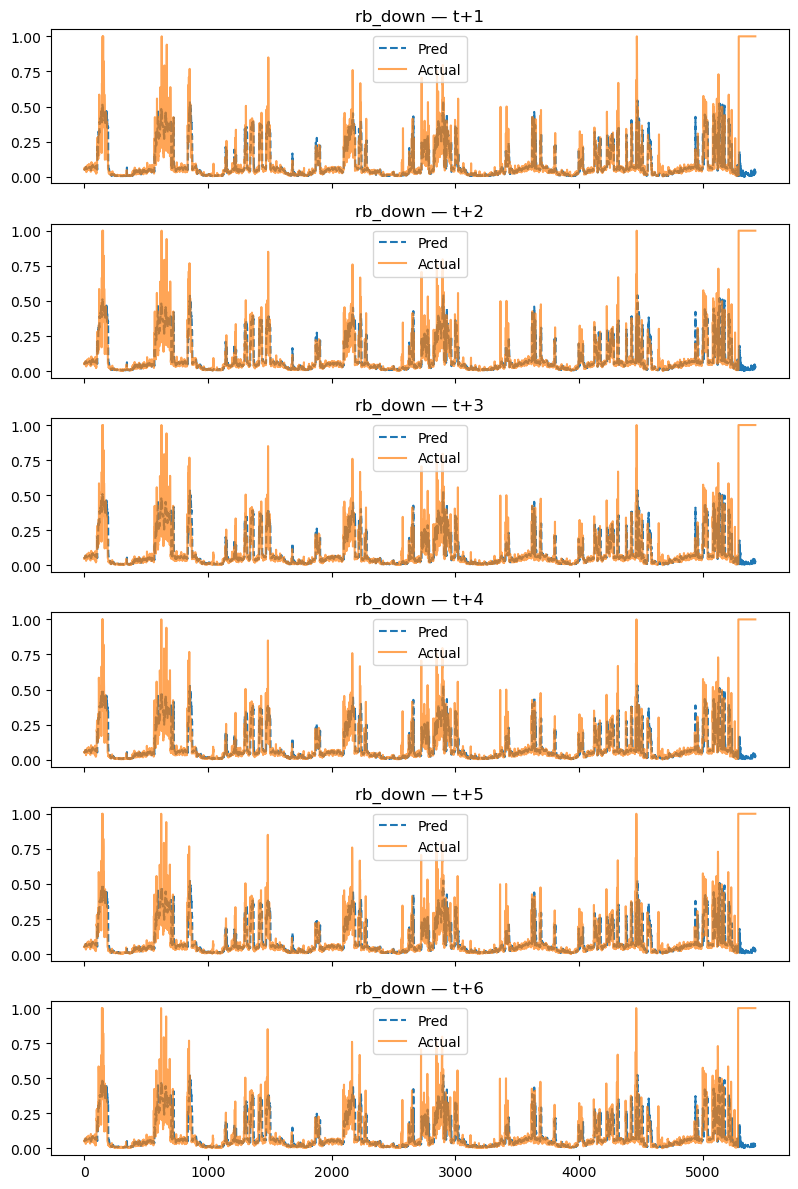

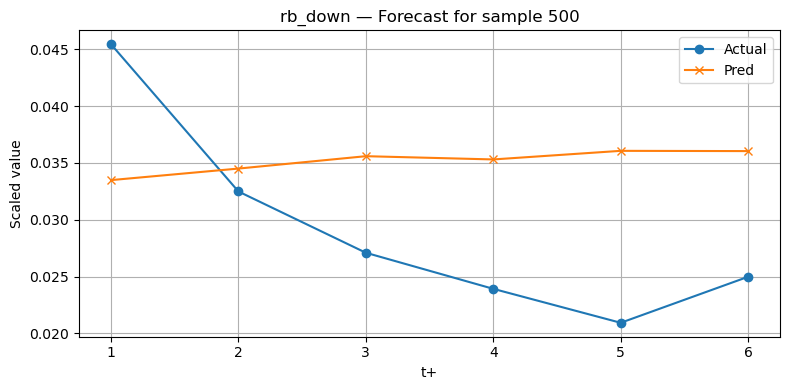


Forecast plots for down


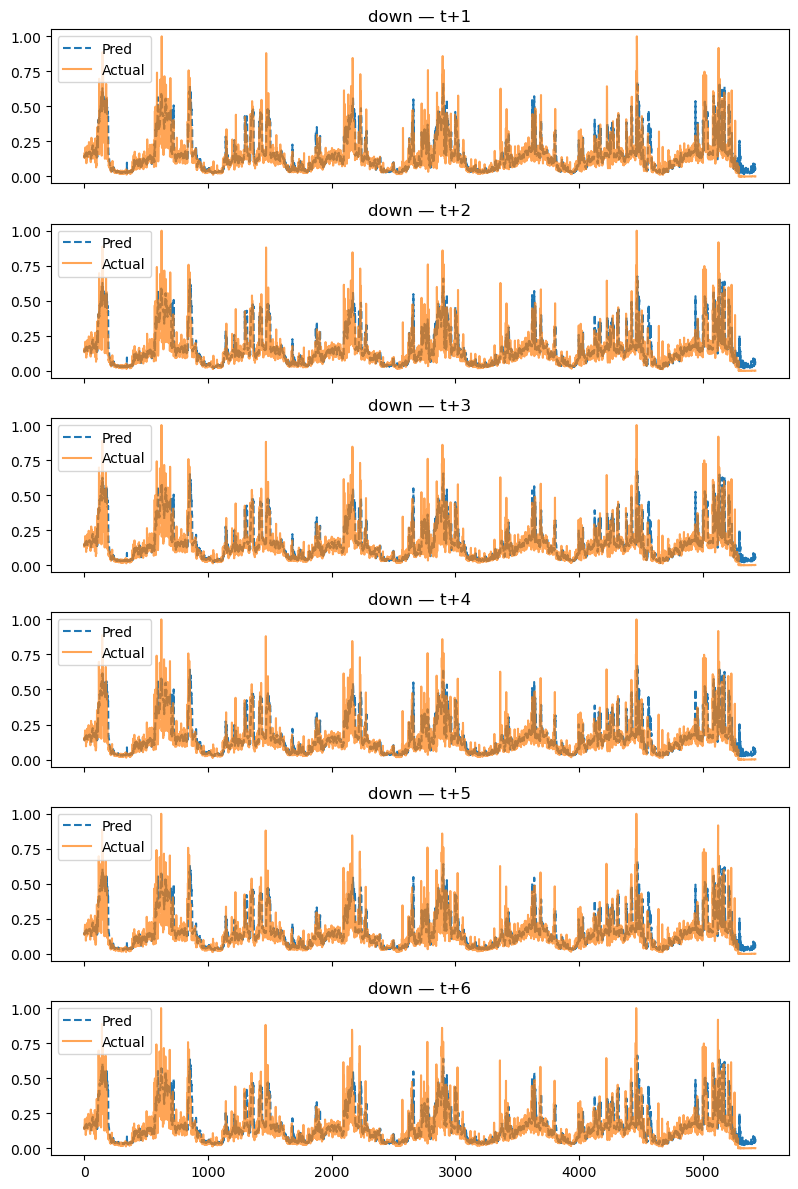

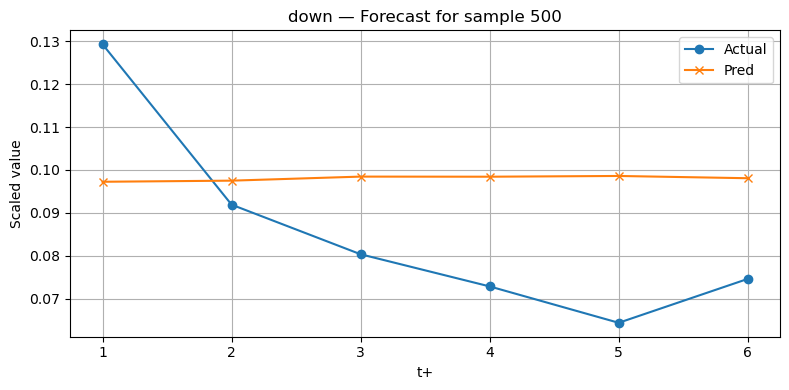

In [15]:
# ─────────────────────────────────────────────────────────────
# 7) Visualizations (same patterns you used before)
def plot_all_steps(preds, y_test, var_name):
    """Plot all 6 horizons as 6 subplots for one variable."""
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(args.forecast_steps):
        axs[t].plot(preds[:, t, idx], label='Pred', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    """Plot t+1..t+6 for a single sample for one variable."""
    idx = args.targets.index(var_name)
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, args.forecast_steps+1), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, args.forecast_steps+1), preds[sample_idx, :, idx], label="Pred", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+"); plt.ylabel("Scaled value")
    plt.xticks(range(1, args.forecast_steps+1))
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)